<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Downloading the CIFAR-100 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


**Resizing images**

Let's normalise our data

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Convert labels to a category format

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

Setting up the image generator for the CIFAR-100 dataset with increasing image size

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

datagen.fit(x_train)


Download the basic EfficientNetB0 model without the top layer

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

Add new layers

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Додавання Dropout шару
predictions = Dense(100, activation='softmax')(x)

Now we can create a new model

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

We can try to frost base layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

Let's compile our new model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now we can train our new model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
391/391 [==============================] - 46s 103ms/step - loss: 4.3483 - accuracy: 0.0537 - val_loss: 4.8700 - val_accuracy: 0.0177
Epoch 2/15
391/391 [==============================] - 38s 97ms/step - loss: 4.1066 - accuracy: 0.0826 - val_loss: 4.9913 - val_accuracy: 0.0225
Epoch 3/15
391/391 [==============================] - 38s 96ms/step - loss: 4.0186 - accuracy: 0.0953 - val_loss: 4.8795 - val_accuracy: 0.0262
Epoch 4/15
391/391 [==============================] - 38s 98ms/step - loss: 3.9582 - accuracy: 0.1055 - val_loss: 5.0087 - val_accuracy: 0.0257
Epoch 5/15
391/391 [==============================] - 38s 97ms/step - loss: 3.9103 - accuracy: 0.1100 - val_loss: 5.4118 - val_accuracy: 0.0243
Epoch 6/15
391/391 [==============================] - 36s 93ms/step - loss: 3.8844 - accuracy: 0.1147 - val_loss: 4.9073 - val_accuracy: 0.0260
Epoch 7/15
391/391 [==============================] - 37s 94ms/step - loss: 3.8624 - accuracy: 0.1183 - val_loss: 4.8226 - val_accuracy

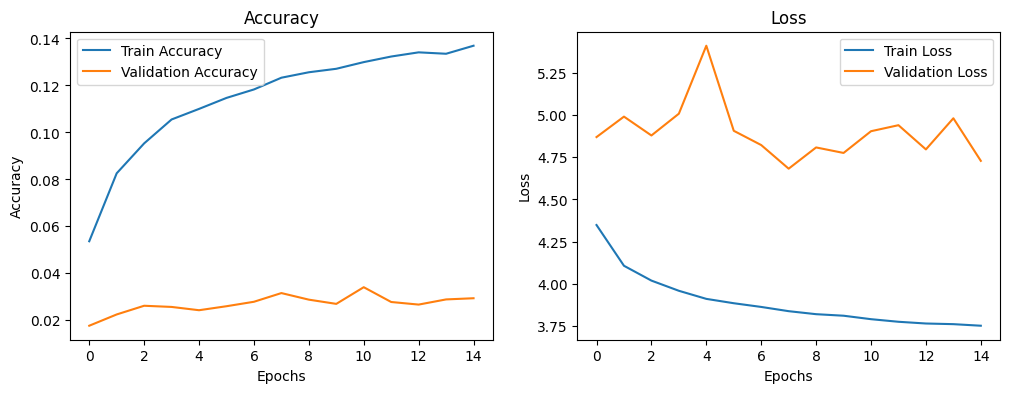

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Defrost all layers of the base model for fine-tuning

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

Recompile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Additional training of the model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 85s 129ms/step - loss: 8.0735 - accuracy: 0.0290 - val_loss: 828.0027 - val_accuracy: 0.0107
Epoch 2/20
391/391 [==============================] - 45s 115ms/step - loss: 4.4930 - accuracy: 0.0484 - val_loss: 17.3234 - val_accuracy: 0.0309
Epoch 3/20
391/391 [==============================] - 45s 115ms/step - loss: 4.1878 - accuracy: 0.0753 - val_loss: 9.5612 - val_accuracy: 0.0480
Epoch 4/20
391/391 [==============================] - 47s 120ms/step - loss: 3.9936 - accuracy: 0.1018 - val_loss: 6.8787 - val_accuracy: 0.0568
Epoch 5/20
391/391 [==============================] - 47s 120ms/step - loss: 3.8466 - accuracy: 0.1210 - val_loss: 5.8898 - val_accuracy: 0.0631
Epoch 6/20
391/391 [==============================] - 46s 118ms/step - loss: 3.7043 - accuracy: 0.1392 - val_loss: 4.8859 - val_accuracy: 0.0724
Epoch 7/20
391/391 [==============================] - 47s 119ms/step - loss: 3.5670 - accuracy: 0.1624 - val_loss: 5.1769 - val

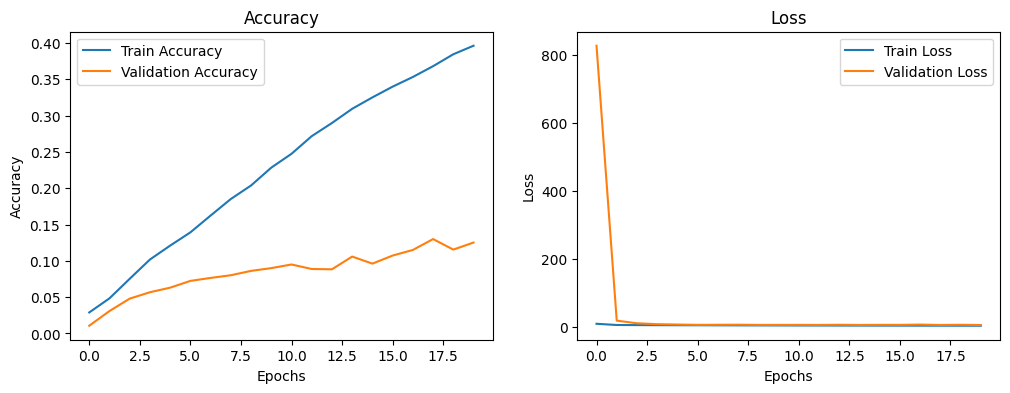

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluation of the model

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print(f"Test accuracy: {scores[1]*100:.2f}%")

313/313 [==============================] - 4s 12ms/step - loss: 4.4441 - accuracy: 0.1252
Test accuracy: 12.52%
